# ImageNet Fine Tuning Top 10
This experiment will involve further fine-tuning the pretrained Xception model. It will explore retraining past the 8 top layers of the base model and for more epochs. The binary labels will be removed to compare multi-class vs binary classification tasks. Class weight-based training and image loading parallelization will be attempted.

In [1]:
!nvidia-smi

Wed Aug 14 01:43:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.28.03              Driver Version: 560.28.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:3A:00.0 Off |                    0 |
| N/A   29C    P0             39W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install --upgrade pip

In [3]:
# !pip install tensorflow[and-cuda]

In [4]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-08-14 01:43:06.835695: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-14 01:43:06.852536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 01:43:06.868887: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 01:43:06.873646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 01:43:06.885923: I tensorflow/core/platform/cpu_feature_guar

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [96]:
import numpy as np
import keras
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping
import math
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from time import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
# from torch.utils.data import DataLoader, Dataset

In [7]:
!pwd
!ls koa_scratch

/home/jctactay
images


In [16]:
# load images
def load_img(path):
    img = Image.open(path)
    img = img.resize((128,128))
    np_img = np.array(img)/255
    return os.path.basename(path), np_img
def load_images_into_dict(img_dir):
    imgs = {}
    paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]

    num_workers = 8
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_img = {executor.submit(load_img, path): path for path in paths}

        for future in as_completed(future_to_img):
            img_name, img = future.result()
            imgs[img_name] = img

    return imgs
    
t0 = time()
home = "/home/jctactay/koa_scratch/images"

imgs = load_images_into_dict(home)
print(f"Done in {time() - t0: .3f}s")

Done in  144.343s


In [18]:
# load/reconcile labels
cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]
labels1[['quality', 'distinctiveness']] = labels1[['distinctiveness', 'quality']]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [19]:
print(len(imgs))

3613


In [20]:
is_na = labels.quality.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')

img_names = labels.image.tolist()
features = {k: v for k, v in imgs.items() if k in img_names}
assert len(features) == len(labels)

In [21]:
labels.quality.value_counts()

quality
2    1479
1    1116
3     991
Name: count, dtype: int64

In [23]:
# check for nans
for k, v in zip(features.keys(), features.values()):
    if np.isnan(v.any()):
        print(k)

In [24]:
print(labels)

                 species                           image  distinctiveness  \
0        spinner_dolphin              0011f7a65044e4.jpg              2.0   
1        spinner_dolphin              007097146016e6.jpg              2.0   
2        spinner_dolphin              009a307f9f483c.jpg              2.0   
3        spinner_dolphin              00eea1a5b9d8bc.jpg              2.0   
4        spinner_dolphin              01287e826d29a8.jpg              2.0   
...                  ...                             ...              ...   
3587  melon_headed_whale  PIFSC_20110503-S3_C-5088a-.jpg              2.0   
3588  melon_headed_whale  PIFSC_20110503-S3_Z-3913a-.jpg              1.0   
3589  melon_headed_whale  PIFSC_20110503-S3_Z-3914ed.jpg              NaN   
3590  melon_headed_whale  PIFSC_20110503-S3_C-4846a-.jpg              1.0   
3591  melon_headed_whale  PIFSC_20110503-S3_Z-3866ed.jpg              1.0   

      quality  
0           3  
1           2  
2           1  
3          

In [25]:
Y = labels.quality
if min(np.unique(Y)) != 0:
    for i in range(len(Y)):
        Y.iat[i] -= 1
print(np.unique(Y))
X = np.array([features[i] for i in labels.image])
print(len(Y))
print(len(X))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train, random_state=42)

[0 1 2]
3586
3586


In [26]:
print(len(X_train), len(X_val), len(X_test))

2151 717 718


In [27]:
# weights per sample instead of per class
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
print(class_weights)
class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
sample_weights = np.array([class_weights_dict[label] for label in Y_train])
sample_weights

[1.07174888 0.80834273 1.20504202]


array([1.20504202, 1.07174888, 0.80834273, ..., 0.80834273, 1.20504202,
       1.20504202])

In [94]:
# load pretrained model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False)
# freeze base model
base_model.trainable = False

In [97]:
# modify input layer
inputs = keras.Input(shape=(128,128,3))
scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(inputs)
# inference mode so weights do not update)
x = base_model(inputs, training=False)
# new trainable layers
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.4)(x)
# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary(show_trainable=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_10 (InputLayer) │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_8  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_16 (Dense)            │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_10 (Dropout)        │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_17 (Dense)            │ (None, 3)             │      3,075 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 22,962,731 (87.60 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [30]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

In [31]:
def plot_history(history):
    num_subplots = len(history.history.keys())//2
    fig, ax = plt.subplots(num_subplots)
    for i, metric in enumerate(history.history.keys()):
        ax[i%num_subplots].plot(history.history[metric], label=metric)
        ax[i%num_subplots].legend()

## Initial fit

In [40]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)

Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.4174 - loss: 1.5980 - val_accuracy: 0.4686 - val_loss: 1.0358
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.4867 - loss: 0.9772 - val_accuracy: 0.4812 - val_loss: 0.9963
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5202 - loss: 0.9040 - val_accuracy: 0.4310 - val_loss: 1.0733
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5368 - loss: 0.8929 - val_accuracy: 0.5216 - val_loss: 0.9619
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5600 - loss: 0.8808 - val_accuracy: 0.5258 - val_loss: 0.9835


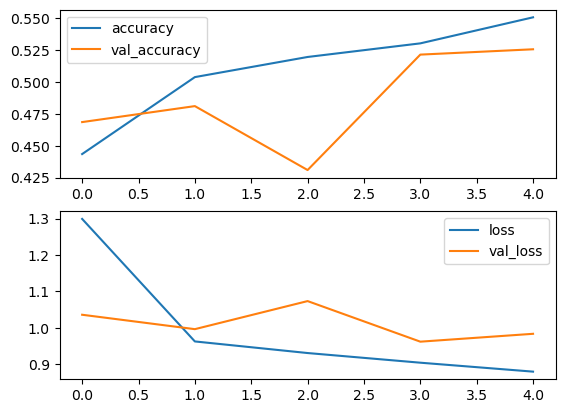

In [41]:
plot_history(history)

In [42]:
results = model.evaluate(X_test, Y_test)
print("test loss, test acc:", results)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.4624 - loss: 1.0487
test loss, test acc: [1.023245930671692, 0.48328691720962524]


## Top 4 layers

In [44]:
# unfreeze top 4 base layers
for layer in base_model.layers[-4:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_4 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_3  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_6 (Dense)             │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_7 (Dense)             │ (None, 3)             │      3,075 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 27,165,235 (103.63 MB)

 Trainable params: 5,264,899 (20.08 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

 Optimizer params: 4,202,504 (16.03 MB)

In [45]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)

In [56]:
# top 4 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=20
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=32, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.4926 - loss: 0.9631 - val_accuracy: 0.5091 - val_loss: 0.9844
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5371 - loss: 0.9283 - val_accuracy: 0.5146 - val_loss: 0.9716
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5435 - loss: 0.9102 - val_accuracy: 0.5160 - val_loss: 0.9672
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5611 - loss: 0.8786 - val_accuracy: 0.5132 - val_loss: 0.9583
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5820 - loss: 0.8651 - val_accuracy: 0.5188 - val_loss: 0.9488
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5787 - loss: 0.8594 - val_accuracy: 0.5146 - val_loss: 0.9487
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5978 - loss: 0.8570 - val_accuracy: 0.5244 - val_loss: 0.9452
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5951 - loss: 0.8250 - val_accuracy: 0.5174 -

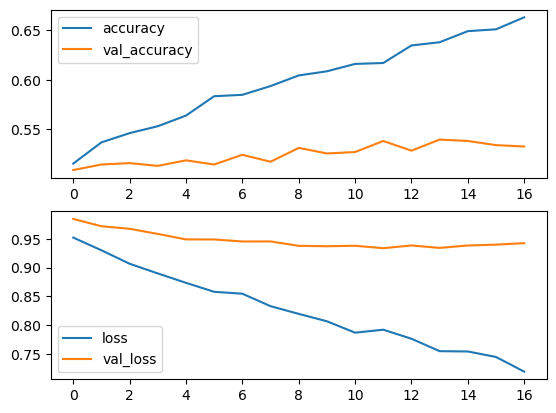

In [57]:
plot_history(history)

In [58]:
results = model.evaluate(X_test, Y_test)
print("test loss, test acc:", results)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5419 - loss: 0.9104
test loss, test acc: [0.9119476675987244, 0.5459610223770142]


## Top 8 layers

In [74]:
# unfreeze 4 more base layers
for layer in base_model.layers[-8:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_7 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_6  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_14 (Dense)            │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_9 (Dropout)         │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_15 (Dense)            │ (None, 3)             │      3,075 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 22,962,731 (87.60 MB)

 Trainable params: 6,852,099 (26.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

In [60]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=10)

In [61]:
sample_weights

array([1.20504202, 1.07174888, 0.80834273, ..., 0.80834273, 1.20504202,
       1.20504202])

In [75]:
# top 8 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=40
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=64, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)

Epoch 1/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.3790 - loss: 1.0942 - val_accuracy: 0.4533 - val_loss: 1.0542
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4909 - loss: 1.0080 - val_accuracy: 0.5049 - val_loss: 1.0195
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5558 - loss: 0.9508 - val_accuracy: 0.5328 - val_loss: 0.9938
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5812 - loss: 0.8927 - val_accuracy: 0.5397 - val_loss: 0.9756
Epoch 5/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6295 - loss: 0.8502 - val_accuracy: 0.5425 - val_loss: 0.9629
Epoch 6/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6473 - loss: 0.7973 - val_accuracy: 0.5537 - val_loss: 0.9510
Epoch 7/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6581 - loss: 0.7819 - val_accuracy: 0.5621 - val_loss: 0.9423
Epoch 8/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6527 - loss: 0.7583 - val_accuracy: 0.5676 

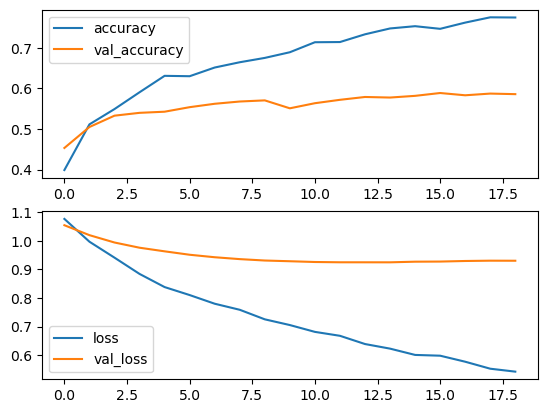

In [76]:
plot_history(history)

In [77]:
results = model.evaluate(X_test, Y_test)
results

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5622 - loss: 0.8956


[0.8832364082336426, 0.5668523907661438]

In [78]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step
              precision    recall  f1-score   support

           0       0.57      0.66      0.61       224
           1       0.53      0.45      0.49       296
           2       0.60      0.64      0.62       198

    accuracy                           0.57       718
   macro avg       0.57      0.58      0.57       718
weighted avg       0.56      0.57      0.56       718



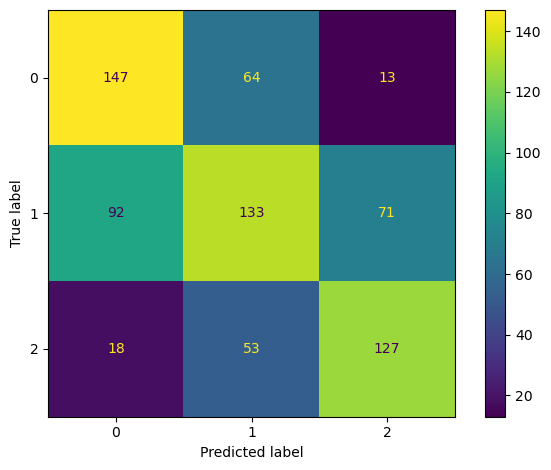

In [79]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

## Top 10 layers

In [98]:
# unfreeze 2 more base layers
for layer in base_model.layers[-10:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_10 (InputLayer) │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_8  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_16 (Dense)            │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_10 (Dropout)        │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_17 (Dense)            │ (None, 3)             │      3,075 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 22,962,731 (87.60 MB)

 Trainable params: 7,597,571 (28.98 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

In [103]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=15)

In [104]:
# top 10 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(5e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=40
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=32, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.5963 - loss: 12.2805 - val_accuracy: 0.5216 - val_loss: 12.2342
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.5719 - loss: 12.1219 - val_accuracy: 0.5258 - val_loss: 12.0668
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5953 - loss: 11.9329 - val_accuracy: 0.5230 - val_loss: 11.9038
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5786 - loss: 11.7750 - val_accuracy: 0.5342 - val_loss: 11.7440
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5795 - loss: 11.5990 - val_accuracy: 0.5356 - val_loss: 11.5899
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6062 - loss: 11.4398 - val_accuracy: 0.5411 - val_loss: 11.4404
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6071 - loss: 11.2875 - val_accuracy: 0.5425 - val_loss: 11.2941
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6229 - loss: 11.1462 - val_ac

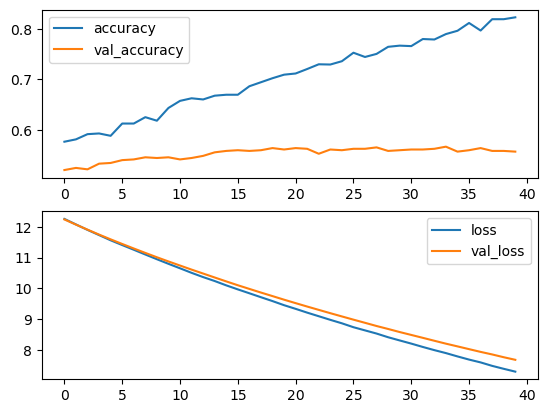

In [105]:
plot_history(history)

In [106]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step
              precision    recall  f1-score   support

           0       0.60      0.65      0.62       224
           1       0.55      0.48      0.51       296
           2       0.60      0.66      0.63       198

    accuracy                           0.58       718
   macro avg       0.58      0.59      0.59       718
weighted avg       0.58      0.58      0.58       718



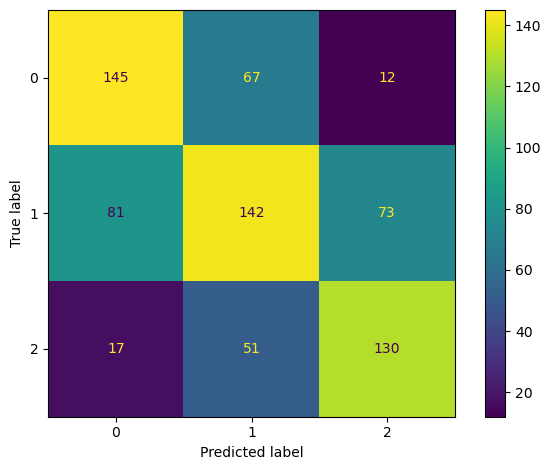

In [107]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()